In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import Normalizer
import warnings
warnings.simplefilter('ignore')

In [2]:
# Print dataset file structure
def print_dir_structure(root_dir, indent=""):
    for item in os.listdir(root_dir):
        path = os.path.join(root_dir, item)
        if os.path.isdir(path):
            print(f"{indent} {item}")
            print_dir_structure(path, indent + "\t")
        else:
            print(f"{indent} {item}")

root_dir = "../Dataset"
print(root_dir)
print_dir_structure(root_dir)

../Dataset
 Benign&Bruteforce
	 benign
		 BenignTraffic.pcap_Flow.csv
		 BenignTraffic1.pcap_Flow.csv
		 BenignTraffic2.pcap_Flow.csv
		 BenignTraffic3.pcap_Flow.csv
	 BruteForce
		 DictionaryBruteForce.pcap_Flow.csv
 DDoS
	 DDoS ACK Fragmentation
		 DDoS-ACK_Fragmentation.pcap_Flow.csv
		 DDoS-ACK_Fragmentation1.pcap_Flow.csv
		 DDoS-ACK_Fragmentation10.pcap_Flow.csv
		 DDoS-ACK_Fragmentation11.pcap_Flow.csv
		 DDoS-ACK_Fragmentation12.pcap_Flow.csv
		 DDoS-ACK_Fragmentation2.pcap_Flow.csv
		 DDoS-ACK_Fragmentation3.pcap_Flow.csv
		 DDoS-ACK_Fragmentation4.pcap_Flow.csv
		 DDoS-ACK_Fragmentation5.pcap_Flow.csv
		 DDoS-ACK_Fragmentation6.pcap_Flow.csv
		 DDoS-ACK_Fragmentation7.pcap_Flow.csv
		 DDoS-ACK_Fragmentation8.pcap_Flow.csv
		 DDoS-ACK_Fragmentation9.pcap_Flow.csv
	 DDoS ICMP Flood
		 DDoS-ICMP_Flood.pcap_Flow.csv
		 DDoS-ICMP_Flood1.pcap_Flow.csv
		 DDoS-ICMP_Flood10.pcap_Flow.csv
		 DDoS-ICMP_Flood11.pcap_Flow.csv
		 DDoS-ICMP_Flood12.pcap_Flow.csv
		 DDoS-ICMP_Flood13.pcap_F

In [3]:
# Define categories
categories = {
    "Benign": ["Benign&Bruteforce/benign"],
    "BruteForce": ["Benign&Bruteforce/BruteForce"],
    "DDoS": ["DDoS"],
    "DoS": ["DoS"],
    "Mirai": ["Mirai"],
    "Spoofing": ["spoofing"],
    "SQLInjection": ["sqlinjection"],
    "VulnerabilityScan": ["VulnerabilityScan"],
    "XSS": ["XSS"],
    "UploadingAttack": ["Uploading_Attack"]
}

# Scan csv files in each category
category_files = {}
for category, paths in categories.items():
    file_list = []
    for category_path in paths:
        full_path = os.path.join(root_dir, category_path)
        for root, _, files in os.walk(full_path):
            for f in files:
                if f.endswith(".csv"):
                    file_list.append(os.path.join(root, f))
    category_files[category] = file_list
print(category_files["Benign"])

['../Dataset\\Benign&Bruteforce/benign\\BenignTraffic.pcap_Flow.csv', '../Dataset\\Benign&Bruteforce/benign\\BenignTraffic1.pcap_Flow.csv', '../Dataset\\Benign&Bruteforce/benign\\BenignTraffic2.pcap_Flow.csv', '../Dataset\\Benign&Bruteforce/benign\\BenignTraffic3.pcap_Flow.csv']


In [4]:
# Define features
get_columns = pd.read_csv(category_files["Benign"][0])
columns = get_columns.columns.tolist()

# Extract data from each category
NUM_SAMPLES = 10000
all_samples = []

for category, files in category_files.items():
    num_files = len(files)
    
    # Skip empty categories
    if num_files == 0:
        continue

    # Read all CSV files
    dataframes = []
    for f in files:
        df = pd.read_csv(f)
        df.columns = columns
        dataframes.append(df)
    
    # Compute the total number of samples available
    total_available = sum(len(df) for df in dataframes)

    # If the number of samples in the class is not enough, all of them are extracted. 
    # Otherwise, the same number of samples are extracted randomly from each CSV file equally.
    if total_available <= NUM_SAMPLES:
        category_df = pd.concat(dataframes, ignore_index=True)
    else:
        category_samples = []
        remaining_samples = NUM_SAMPLES

        # First, take the minimum possible from each file
        for df in dataframes:
            extract = min(len(df), remaining_samples // len(files))
            category_samples.append(df.sample(n=extract, random_state=42))
            remaining_samples -= extract

        # If still need more, distribute the remainder randomly
        if remaining_samples > 0:
            available_files = [df for df in dataframes if len(df) > NUM_SAMPLES // len(files)]
            for df in available_files:
                if remaining_samples <= 0:
                    break
                extra = min(len(df), remaining_samples)
                category_samples.append(df.sample(n=extra, random_state=42))
                remaining_samples -= extra

        # Merge all sampled data
        category_df = pd.concat(category_samples, ignore_index=True)

    category_df["Label"] = category  # Add label column
    all_samples.append(category_df)
    
extracted_dataset = pd.concat(all_samples, ignore_index=True)
extracted_dataset.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.137.133-192.168.137.1-53083-53-17,192.168.137.133,53083,192.168.137.1,53,17,07/10/2022 07:17:29 PM,40091,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,192.168.137.133-192.168.137.1-34173-53-17,192.168.137.133,34173,192.168.137.1,53,17,07/10/2022 07:45:10 PM,114039,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,192.168.137.227-8.8.8.8-50664-53-17,192.168.137.227,50664,8.8.8.8,53,17,07/10/2022 04:17:53 PM,131314,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,192.168.137.41-192.168.137.1-60462-53-17,192.168.137.41,60462,192.168.137.1,53,17,07/10/2022 06:28:11 PM,16452,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,192.168.137.245-47.254.89.110-19274-32100-17,192.168.137.245,19274,47.254.89.110,32100,17,07/10/2022 09:12:16 PM,100400129,5,5,...,8,128562.0,4110.726213,133735.0,124588.0,24937178.0,12621.024443,24951903.0,24921500.0,Benign


In [5]:
extracted_dataset['Label'].value_counts()

Label
Benign               10000
DDoS                 10000
VulnerabilityScan    10000
DoS                  10000
Mirai                10000
Spoofing             10000
SQLInjection          6603
BruteForce            3619
XSS                   3377
UploadingAttack       1348
Name: count, dtype: int64

In [6]:
extracted_dataset.describe()

,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,...,Fwd Segment Size Avg,Bwd Segment Size Avg,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,7.494700e+04,7.494700e+04,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,...,74947.000000,74947.000000,7.494700e+04,7.494700e+04,7.494700e+04,7.494700e+04,7.494700e+04,7.494700e+04,7.494700e+04,7.494700e+04
mean,2.611461e+03,2.251543e+03,178.025338,87.167692,108.512896,31.208325,187.120112,84.048781,108.486509,37.703265,...,108.512896,108.486509,7.742393e+05,2.791422e+05,1.096997e+06,5.575131e+05,8.125219e+06,6.624698e+05,8.908148e+06,7.569882e+06
std,8.178722e+04,1.515049e+05,618.728122,272.534399,287.372134,121.025269,529.615128,275.735415,297.094987,160.519660,...,287.372134,297.094987,3.670345e+06,1.816787e+06,5.004777e+06,3.046737e+06,1.892345e+07,3.546590e+06,1.976712e+07,1.866683e+07
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.600000e+01,2.800000e+01,41.000000,4.000000,36.000000,0.000000,20.000000,0.000000,20.000000,0.000000,...,36.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.480000e+02,1.320000e+02,120.000000,48.000000,65.000000,0.000000,70.000000,48.000000,63.000000,0.000000,...,65.000000,63.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.625941e+06,0.000000e+00,7.628318e+06,5.575825e+06
max,8.465404e+06,3.074290e+07,28960.000000,4344.000000,4344.000000,2977.474224,14600.000000,2792.000000,3357.222222,2796.403244,...,4344.000000,3357.222222,1.120029e+08,5.886600e+07,1.120029e+08,1.120029e+08,1.199952e+08,7.229957e+07,1.199952e+08,1.199952e+08


In [7]:
# Drop unnecessary columns, such as ID, IP, Port, Protocol and TimeStamp
extracted_dataset = extracted_dataset.drop(['Flow ID','Src IP','Src Port','Dst IP','Dst Port','Protocol','Timestamp', 'Flow Bytes/s', 'Flow Packets/s'], axis=1)
extracted_dataset.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,40091,1,1,35.0,51.0,35.0,35.0,35.0,0.0,51.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,114039,1,1,36.0,52.0,36.0,36.0,36.0,0.0,52.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,131314,1,1,54.0,70.0,54.0,54.0,54.0,0.0,70.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,16452,1,1,28.0,44.0,28.0,28.0,28.0,0.0,44.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,100400129,5,5,540.0,40.0,108.0,108.0,108.0,0.0,8.0,...,8,128562.0,4110.726213,133735.0,124588.0,24937178.0,12621.024443,24951903.0,24921500.0,Benign


In [8]:
# Drop missing values
extracted_dataset = extracted_dataset.dropna()

# Random over sampling
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(extracted_dataset.iloc[:, :-1], extracted_dataset.iloc[:, -1])
processed_data = pd.DataFrame(X)
processed_data['Label'] = y
processed_data['Label'].value_counts()

Label
Benign               10000
BruteForce           10000
DDoS                 10000
DoS                  10000
Mirai                10000
Spoofing             10000
SQLInjection         10000
VulnerabilityScan    10000
XSS                  10000
UploadingAttack      10000
Name: count, dtype: int64

<Axes: title={'center': 'Label Distribution'}>

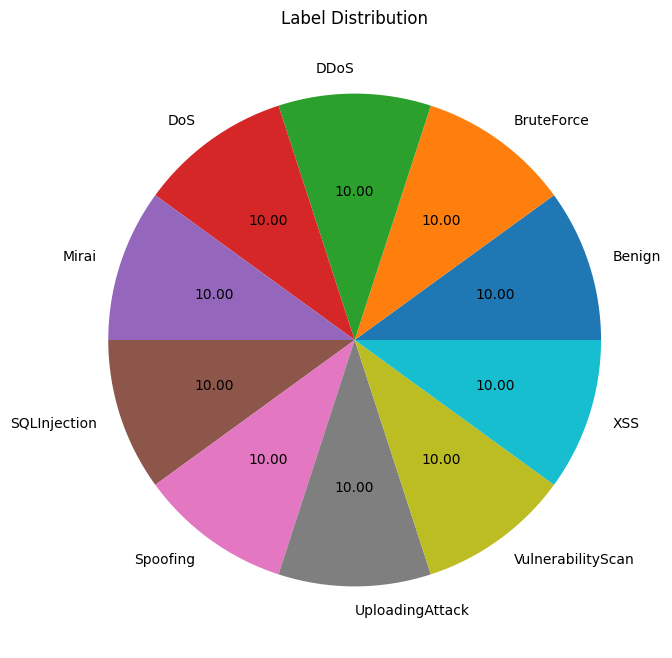

In [9]:
plt.title("Label Distribution")
processed_data.groupby('Label').size().plot(kind='pie', autopct='%.2f', figsize=(8,8))

In [10]:
# Encode the labels
category_mapping = {
    'Benign': 0,
    'DDoS': 1,
    'DoS': 2,
    'VulnerabilityScan': 3,
    'Mirai': 4,
    'Spoofing': 5,
    'BruteForce': 6,
    'XSS': 7,
    'UploadingAttack': 8,
    'SQLInjection': 9
}
processed_data['Label'] = processed_data['Label'].map(category_mapping)
print(processed_data['Label'].unique())

[0 6 1 2 4 5 9 3 7 8]


In [11]:
# Assign clients ID
processed_data["Client_ID"] = np.random.randint(1, 6, size=len(processed_data))
processed_data["Client_ID"].value_counts()

Client_ID
1    20350
3    19994
5    19958
2    19868
4    19830
Name: count, dtype: int64

<Axes: title={'center': 'Clients Distribution'}>

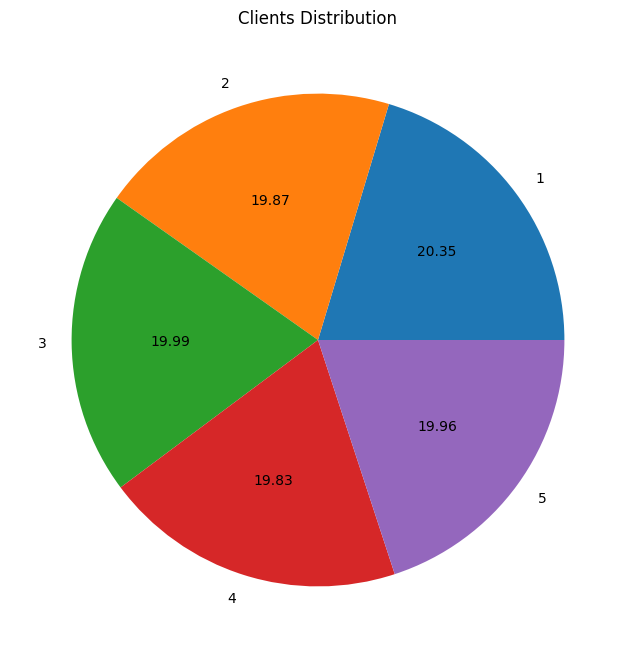

In [12]:
plt.title("Clients Distribution")
processed_data.groupby('Client_ID').size().plot(kind='pie', autopct='%.2f', figsize=(8,8))

In [13]:
# Normalize the data
scaler = Normalizer(norm='l2')
normalize_data = processed_data.columns[:-2]
processed_data[normalize_data] = scaler.fit_transform(processed_data[normalize_data])
processed_data.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Client_ID
0,0.499999,1.247159e-05,1.247159e-05,0.000437,6.360511e-04,4.365057e-04,4.365057e-04,4.365057e-04,0.0,6.360511e-04,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,5
1,0.500000,4.384463e-06,4.384463e-06,0.000158,2.279921e-04,1.578407e-04,1.578407e-04,1.578407e-04,0.0,2.279921e-04,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,1
2,0.500000,3.807665e-06,3.807665e-06,0.000206,2.665366e-04,2.056139e-04,2.056139e-04,2.056139e-04,0.0,2.665366e-04,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,1
3,0.499992,3.039095e-05,3.039095e-05,0.000851,1.337202e-03,8.509467e-04,8.509467e-04,8.509467e-04,0.0,1.337202e-03,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,3
4,0.523786,2.608494e-08,2.608494e-08,0.000003,2.086795e-07,5.634346e-07,5.634346e-07,5.634346e-07,0.0,4.173590e-08,...,0.000671,0.000021,0.000698,0.00065,0.130097,0.000066,0.130174,0.130015,0,1


In [14]:
# Shuffle the dataset
processed_data = processed_data.sample(frac=1).reset_index(drop=True)
processed_data.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Client_ID
0,0.500000,3.560924e-06,3.560924e-06,0.000014,0.000071,0.000014,0.000014,0.000014,0.000000,0.000071,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,3,2
1,0.329578,7.284024e-05,3.642012e-05,0.007830,0.004055,0.007454,0.000000,0.001305,0.003016,0.002222,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,5,3
2,0.628656,6.967665e-08,2.787066e-07,0.000005,0.000043,0.000005,0.000005,0.000005,0.000000,0.000011,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,7,1
3,0.549076,4.413455e-06,4.045667e-06,0.000310,0.001519,0.000137,0.000000,0.000026,0.000042,0.000533,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,3,2
4,0.377950,1.216833e-08,1.216833e-08,0.000018,0.000000,0.000018,0.000018,0.000018,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.37795,0.0,0.37795,0.37795,1,1


In [15]:
processed_data['Label'].value_counts()

Label
3    10000
5    10000
7    10000
1    10000
2    10000
9    10000
6    10000
4    10000
8    10000
0    10000
Name: count, dtype: int64

In [16]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow Duration               100000 non-null  float64
 1   Total Fwd Packet            100000 non-null  float64
 2   Total Bwd packets           100000 non-null  float64
 3   Total Length of Fwd Packet  100000 non-null  float64
 4   Total Length of Bwd Packet  100000 non-null  float64
 5   Fwd Packet Length Max       100000 non-null  float64
 6   Fwd Packet Length Min       100000 non-null  float64
 7   Fwd Packet Length Mean      100000 non-null  float64
 8   Fwd Packet Length Std       100000 non-null  float64
 9   Bwd Packet Length Max       100000 non-null  float64
 10  Bwd Packet Length Min       100000 non-null  float64
 11  Bwd Packet Length Mean      100000 non-null  float64
 12  Bwd Packet Length Std       100000 non-null  float64
 13  Flow IAT Mean  

In [17]:
processed_data.describe()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Client_ID
count,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.482363,8.005928e-05,1.410103e-05,0.001209,0.000922,0.000697,0.000602,0.000631,0.000048,0.000737,...,0.005912,0.001610,0.007776,0.004677,0.057829,0.004171,0.062589,0.054335,4.500000,2.991780
std,0.137416,1.196808e-03,4.342953e-05,0.006548,0.004888,0.002845,0.002757,0.002785,0.000346,0.002071,...,0.027183,0.010599,0.033443,0.024584,0.107916,0.018947,0.112779,0.106096,2.872296,1.417481
min,0.000000,3.167073e-09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.438263,1.304759e-07,1.063912e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,0.499992,2.689235e-06,1.557153e-06,0.000024,0.000013,0.000010,0.000001,0.000008,0.000000,0.000007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,3.000000
75%,0.554676,1.292780e-05,9.772620e-06,0.000499,0.000719,0.000417,0.000195,0.000232,0.000000,0.000643,...,0.000000,0.000000,0.000000,0.000000,0.051309,0.000000,0.068785,0.035276,7.000000,4.000000
max,0.823457,1.111111e-01,2.594578e-03,0.710069,0.570730,0.284877,0.272917,0.272917,0.047268,0.059374,...,0.421344,0.290970,0.430299,0.421344,0.437071,0.311888,0.467152,0.437071,9.000000,5.000000


In [18]:
# Export the processed dataset
processed_data.to_csv("dataset_multi.csv", index=False, header=True)